#Assignment 3
##Aditya Karthully
###a1899982

### Setup

In [63]:
!pip install optuna -q


### Imports

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import optuna

from datetime import datetime

import random

In [65]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

### Parameters and Settings

In [66]:
N = 30          # Number of past days
M = 1           # Predict next day's close price
batch_size = 32
epochs = 20
patience = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Import Data

In [67]:
TRAIN_FILE = '/content/Google_Stock_Price_Train.csv'
TEST_FILE = '/content/Google_Stock_Price_Test.csv'

### Data preprocessing

In [68]:
data = pd.read_csv(TRAIN_FILE)
test_data = pd.read_csv(TEST_FILE)



In [69]:
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [70]:
test_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [71]:
data.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,object
Volume,object


In [72]:
test_data.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,object


In [73]:
data['Date'] = pd.to_datetime(data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])
data = data.sort_values('Date')
test_data = test_data.sort_values('Date')

In [74]:
# Clean 'Close' and 'Volume' in training data
data['Close'] = data['Close'].astype(str).str.replace(',', '').astype(float)
data['Volume'] = data['Volume'].astype(str).str.replace(',', '').astype(float)
test_data['Volume'] = test_data['Volume'].astype(str).str.replace(',', '').astype(float)


In [75]:
data.dtypes

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64


In [76]:
total_data = pd.concat([data, test_data], ignore_index=True)
total_data = total_data.sort_values('Date').reset_index(drop=True)
total_data['Close'].fillna(method='ffill', inplace=True)

### Methodology

In [77]:
def compute_RSI(prices, time_window=14):
    diff = prices.diff(1)
    up_chg = diff.where(diff > 0, 0.0)
    down_chg = -diff.where(diff < 0, 0.0)
    up_chg_avg = up_chg.ewm(com=time_window - 1, adjust=False).mean()
    down_chg_avg = down_chg.ewm(com=time_window - 1, adjust=False).mean()
    rs = up_chg_avg / down_chg_avg
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [78]:
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA10', 'MA20', 'RSI']


In [79]:
total_data['MA10'] = total_data['Close'].rolling(window=10).mean()
total_data['MA20'] = total_data['Close'].rolling(window=20).mean()
total_data['RSI'] = compute_RSI(total_data['Close'], 14)

In [80]:
total_data.dropna(inplace=True)
total_data.reset_index(drop=True, inplace=True)

close_index = features.index('Close')
other_features = [f for f in features if f != 'Close']

### Scaling

In [81]:
close_scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = close_scaler.fit_transform(total_data[['Close']])

other_scaler = MinMaxScaler(feature_range=(0,1))
others_scaled = other_scaler.fit_transform(total_data[other_features])

scaled_data = np.insert(others_scaled, close_index, close_scaled[:,0], axis=1)


In [82]:
full_size = len(scaled_data)
test_size = int(full_size * 0.1)
train_size = int(full_size * 0.8)
val_size = full_size - train_size - test_size

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size+val_size]
test_data_scaled = scaled_data[train_size+val_size:]

In [83]:
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(N, len(data)-M+1):
        X.append(data[i-N:i])
        y.append(data[i:i+M, close_index])
    return np.array(X), np.array(y)



In [84]:
X_train, y_train = create_sequences(train_data, N, M)
X_val, y_val = create_sequences(val_data, N, M)
X_test, y_test = create_sequences(test_data_scaled, N, M)



In [85]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [86]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [87]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [88]:
input_size = len(features)
output_size = M
num_layers = 2
criterion = nn.MSELoss()

### Models

In [89]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, (h,c) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [90]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size=1):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, h = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


In [91]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch).squeeze()
        loss = criterion(preds, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    return epoch_loss / len(dataloader.dataset)

In [92]:
def evaluate(model, criterion, dataloader, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch).squeeze()
            loss = criterion(preds, y_batch.squeeze())
            epoch_loss += loss.item() * X_batch.size(0)
    return epoch_loss / len(dataloader.dataset)

In [93]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=50, patience=5):
    best_val_loss = float('inf')
    best_model_state = None
    wait = 0

    for epoch in range(epochs):
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_loss = evaluate(model, criterion, val_loader, device)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(best_model_state)
    return model, best_val_loss

In [94]:
def objective_lstm(trial):
    hidden_size = trial.suggest_int('units', 32, 256, step=32)
    dropout = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    lr = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])

    model = LSTMModel(input_size, hidden_size, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    _, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, patience=3)
    return val_loss

In [95]:
def objective_gru(trial):
    hidden_size = trial.suggest_int('units', 32, 256, step=32)
    dropout = trial.suggest_float('dropout_rate', 0.0, 0.5, step=0.1)
    lr = trial.suggest_categorical('learning_rate', [1e-2, 1e-3, 1e-4])

    model = GRUModel(input_size, hidden_size, num_layers, dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    _, val_loss = train_model(model, train_loader, val_loader, optimizer, criterion, device, epochs=10, patience=3)
    return val_loss

### Hyper parameter Tuning

In [96]:
study_lstm = optuna.create_study(direction='minimize')
study_lstm.optimize(objective_lstm, n_trials=5)
best_lstm_hps = study_lstm.best_params
print("Best LSTM hyperparameters:", best_lstm_hps)


[I 2024-12-07 01:30:17,849] A new study created in memory with name: no-name-9bb6fd8d-4da1-4533-bb15-92d1d387ed1f


Epoch 1/10, Train Loss: 0.0801, Val Loss: 0.0166
Epoch 2/10, Train Loss: 0.0667, Val Loss: 0.0059
Epoch 3/10, Train Loss: 0.0564, Val Loss: 0.0010
Epoch 4/10, Train Loss: 0.0502, Val Loss: 0.0010
Epoch 5/10, Train Loss: 0.0436, Val Loss: 0.0010
Epoch 6/10, Train Loss: 0.0338, Val Loss: 0.0009
Epoch 7/10, Train Loss: 0.0210, Val Loss: 0.0016
Epoch 8/10, Train Loss: 0.0117, Val Loss: 0.0074


[I 2024-12-07 01:30:20,623] Trial 0 finished with value: 0.0008941286167888375 and parameters: {'units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.0008941286167888375.


Epoch 9/10, Train Loss: 0.0101, Val Loss: 0.0094
Early stopping triggered.
Epoch 1/10, Train Loss: 0.0346, Val Loss: 0.0005
Epoch 2/10, Train Loss: 0.0061, Val Loss: 0.0010
Epoch 3/10, Train Loss: 0.0047, Val Loss: 0.0039


[I 2024-12-07 01:30:24,495] Trial 1 finished with value: 0.0005460560820473492 and parameters: {'units': 96, 'dropout_rate': 0.4, 'learning_rate': 0.01}. Best is trial 1 with value: 0.0005460560820473492.


Epoch 4/10, Train Loss: 0.0037, Val Loss: 0.0029
Early stopping triggered.
Epoch 1/10, Train Loss: 0.1909, Val Loss: 0.0144
Epoch 2/10, Train Loss: 0.0156, Val Loss: 0.0032
Epoch 3/10, Train Loss: 0.0056, Val Loss: 0.0008
Epoch 4/10, Train Loss: 0.0033, Val Loss: 0.0007
Epoch 5/10, Train Loss: 0.0033, Val Loss: 0.0007
Epoch 6/10, Train Loss: 0.0025, Val Loss: 0.0006
Epoch 7/10, Train Loss: 0.0027, Val Loss: 0.0017
Epoch 8/10, Train Loss: 0.0022, Val Loss: 0.0006
Epoch 9/10, Train Loss: 0.0028, Val Loss: 0.0004


[I 2024-12-07 01:30:55,476] Trial 2 finished with value: 0.0003579584278583949 and parameters: {'units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 2 with value: 0.0003579584278583949.


Epoch 10/10, Train Loss: 0.0026, Val Loss: 0.0008
Epoch 1/10, Train Loss: 0.0266, Val Loss: 0.0009
Epoch 2/10, Train Loss: 0.0064, Val Loss: 0.0036
Epoch 3/10, Train Loss: 0.0056, Val Loss: 0.0009


[I 2024-12-07 01:30:56,684] Trial 3 finished with value: 0.0008931386899011037 and parameters: {'units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.01}. Best is trial 2 with value: 0.0003579584278583949.


Epoch 4/10, Train Loss: 0.0042, Val Loss: 0.0010
Early stopping triggered.
Epoch 1/10, Train Loss: 0.1693, Val Loss: 0.0056
Epoch 2/10, Train Loss: 0.0927, Val Loss: 0.0127
Epoch 3/10, Train Loss: 0.0683, Val Loss: 0.0037
Epoch 4/10, Train Loss: 0.0714, Val Loss: 0.0022
Epoch 5/10, Train Loss: 0.0770, Val Loss: 0.0068
Epoch 6/10, Train Loss: 0.0740, Val Loss: 0.0164
Epoch 7/10, Train Loss: 0.0701, Val Loss: 0.0010
Epoch 8/10, Train Loss: 0.0812, Val Loss: 0.0312
Epoch 9/10, Train Loss: 0.0905, Val Loss: 0.0013


[I 2024-12-07 01:31:34,831] Trial 4 finished with value: 0.0009609734898759532 and parameters: {'units': 224, 'dropout_rate': 0.1, 'learning_rate': 0.01}. Best is trial 2 with value: 0.0003579584278583949.


Epoch 10/10, Train Loss: 0.0664, Val Loss: 0.0056
Early stopping triggered.
Best LSTM hyperparameters: {'units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.01}


In [97]:
study_gru = optuna.create_study(direction='minimize')
study_gru.optimize(objective_gru, n_trials=5)
best_gru_hps = study_gru.best_params
print("Best GRU hyperparameters:", best_gru_hps)

[I 2024-12-07 01:31:34,846] A new study created in memory with name: no-name-a4f5c3a1-ad29-4956-b1e1-c0ae2e7e5a3f


Epoch 1/10, Train Loss: 0.0792, Val Loss: 0.0027
Epoch 2/10, Train Loss: 0.0051, Val Loss: 0.0006
Epoch 3/10, Train Loss: 0.0028, Val Loss: 0.0006
Epoch 4/10, Train Loss: 0.0024, Val Loss: 0.0008
Epoch 5/10, Train Loss: 0.0022, Val Loss: 0.0005
Epoch 6/10, Train Loss: 0.0020, Val Loss: 0.0007
Epoch 7/10, Train Loss: 0.0015, Val Loss: 0.0002
Epoch 8/10, Train Loss: 0.0017, Val Loss: 0.0004
Epoch 9/10, Train Loss: 0.0021, Val Loss: 0.0003


[I 2024-12-07 01:31:51,754] Trial 0 finished with value: 0.0001665797132876289 and parameters: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0001665797132876289.


Epoch 10/10, Train Loss: 0.0017, Val Loss: 0.0009
Early stopping triggered.
Epoch 1/10, Train Loss: 0.0715, Val Loss: 0.0007
Epoch 2/10, Train Loss: 0.0497, Val Loss: 0.0009
Epoch 3/10, Train Loss: 0.0383, Val Loss: 0.0013


[I 2024-12-07 01:31:55,357] Trial 1 finished with value: 0.0007311121600238395 and parameters: {'units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.0001665797132876289.


Epoch 4/10, Train Loss: 0.0246, Val Loss: 0.0013
Early stopping triggered.
Epoch 1/10, Train Loss: 0.0586, Val Loss: 0.0095
Epoch 2/10, Train Loss: 0.0173, Val Loss: 0.0011
Epoch 3/10, Train Loss: 0.0049, Val Loss: 0.0009
Epoch 4/10, Train Loss: 0.0043, Val Loss: 0.0006
Epoch 5/10, Train Loss: 0.0041, Val Loss: 0.0015
Epoch 6/10, Train Loss: 0.0039, Val Loss: 0.0013


[I 2024-12-07 01:32:13,190] Trial 2 finished with value: 0.0006024188298453606 and parameters: {'units': 192, 'dropout_rate': 0.2, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.0001665797132876289.


Epoch 7/10, Train Loss: 0.0036, Val Loss: 0.0010
Early stopping triggered.
Epoch 1/10, Train Loss: 0.0532, Val Loss: 0.0010
Epoch 2/10, Train Loss: 0.0042, Val Loss: 0.0019
Epoch 3/10, Train Loss: 0.0027, Val Loss: 0.0003
Epoch 4/10, Train Loss: 0.0024, Val Loss: 0.0004
Epoch 5/10, Train Loss: 0.0020, Val Loss: 0.0007


[I 2024-12-07 01:32:19,836] Trial 3 finished with value: 0.00031214828642574856 and parameters: {'units': 64, 'dropout_rate': 0.0, 'learning_rate': 0.001}. Best is trial 0 with value: 0.0001665797132876289.


Epoch 6/10, Train Loss: 0.0020, Val Loss: 0.0003
Early stopping triggered.
Epoch 1/10, Train Loss: 0.0858, Val Loss: 0.0004
Epoch 2/10, Train Loss: 0.0034, Val Loss: 0.0032
Epoch 3/10, Train Loss: 0.0026, Val Loss: 0.0014
Epoch 4/10, Train Loss: 0.0021, Val Loss: 0.0003
Epoch 5/10, Train Loss: 0.0017, Val Loss: 0.0002
Epoch 6/10, Train Loss: 0.0014, Val Loss: 0.0010
Epoch 7/10, Train Loss: 0.0019, Val Loss: 0.0014


[I 2024-12-07 01:32:33,131] Trial 4 finished with value: 0.0002389332183850353 and parameters: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01}. Best is trial 0 with value: 0.0001665797132876289.


Epoch 8/10, Train Loss: 0.0018, Val Loss: 0.0020
Early stopping triggered.
Best GRU hyperparameters: {'units': 128, 'dropout_rate': 0.2, 'learning_rate': 0.01}


### Training

In [61]:
lstm_model = LSTMModel(input_size, best_lstm_hps['units'], num_layers, best_lstm_hps['dropout_rate']).to(device)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=best_lstm_hps['learning_rate'])
lstm_model, lstm_val_loss = train_model(lstm_model, train_loader, val_loader, lstm_optimizer, criterion, device, epochs=20, patience=5)


Epoch 1/20, Train Loss: 0.0670, Val Loss: 0.0035
Epoch 2/20, Train Loss: 0.0048, Val Loss: 0.0008
Epoch 3/20, Train Loss: 0.0034, Val Loss: 0.0025
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0004
Epoch 5/20, Train Loss: 0.0016, Val Loss: 0.0019
Epoch 6/20, Train Loss: 0.0025, Val Loss: 0.0005
Epoch 7/20, Train Loss: 0.0017, Val Loss: 0.0003
Epoch 8/20, Train Loss: 0.0017, Val Loss: 0.0003
Epoch 9/20, Train Loss: 0.0015, Val Loss: 0.0013
Epoch 10/20, Train Loss: 0.0014, Val Loss: 0.0007
Epoch 11/20, Train Loss: 0.0016, Val Loss: 0.0015
Epoch 12/20, Train Loss: 0.0016, Val Loss: 0.0002
Epoch 13/20, Train Loss: 0.0011, Val Loss: 0.0003
Epoch 14/20, Train Loss: 0.0014, Val Loss: 0.0008
Epoch 15/20, Train Loss: 0.0012, Val Loss: 0.0004
Epoch 16/20, Train Loss: 0.0016, Val Loss: 0.0003
Epoch 17/20, Train Loss: 0.0015, Val Loss: 0.0003
Early stopping triggered.


In [62]:
gru_model = GRUModel(input_size, best_gru_hps['units'], num_layers, best_gru_hps['dropout_rate']).to(device)
gru_optimizer = torch.optim.Adam(gru_model.parameters(), lr=best_gru_hps['learning_rate'])
gru_model, gru_val_loss = train_model(gru_model, train_loader, val_loader, gru_optimizer, criterion, device, epochs=20, patience=5)


Epoch 1/20, Train Loss: 0.0237, Val Loss: 0.0004
Epoch 2/20, Train Loss: 0.0036, Val Loss: 0.0014
Epoch 3/20, Train Loss: 0.0033, Val Loss: 0.0003
Epoch 4/20, Train Loss: 0.0021, Val Loss: 0.0008
Epoch 5/20, Train Loss: 0.0026, Val Loss: 0.0023
Epoch 6/20, Train Loss: 0.0020, Val Loss: 0.0003
Epoch 7/20, Train Loss: 0.0016, Val Loss: 0.0002
Epoch 8/20, Train Loss: 0.0017, Val Loss: 0.0002
Epoch 9/20, Train Loss: 0.0016, Val Loss: 0.0002
Epoch 10/20, Train Loss: 0.0015, Val Loss: 0.0003
Epoch 11/20, Train Loss: 0.0015, Val Loss: 0.0005
Epoch 12/20, Train Loss: 0.0015, Val Loss: 0.0002
Epoch 13/20, Train Loss: 0.0016, Val Loss: 0.0006
Epoch 14/20, Train Loss: 0.0019, Val Loss: 0.0003
Early stopping triggered.


In [98]:
def predict(model, dataloader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_batch, _ in dataloader:
            X_batch = X_batch.to(device)
            out = model(X_batch).cpu().numpy()
            preds.append(out)
    return np.concatenate(preds, axis=0)

In [99]:
lstm_preds = predict(lstm_model, test_loader, device)

In [100]:
gru_preds = predict(gru_model, test_loader, device)

In [101]:
def inverse_transform_close(predictions, close_scaler):
    predictions = predictions.reshape(-1, 1)
    return close_scaler.inverse_transform(predictions).flatten()

In [102]:
y_test_inv = inverse_transform_close(y_test, close_scaler)
lstm_preds_inv = inverse_transform_close(lstm_preds, close_scaler)
gru_preds_inv = inverse_transform_close(gru_preds, close_scaler)

In [103]:
def evaluate_metrics(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return rmse, mae, r2, mape


In [104]:
rmse_lstm, mae_lstm, r2_lstm, mape_lstm = evaluate_metrics(y_test_inv, lstm_preds_inv)
rmse_gru, mae_gru, r2_gru, mape_gru = evaluate_metrics(y_test_inv, gru_preds_inv)


In [105]:
print("LSTM Model Performance:")
print(f"RMSE: {rmse_lstm}")
print(f"MAE: {mae_lstm}")
print(f"R2: {r2_lstm}")
print(f"MAPE: {mape_lstm}%")

LSTM Model Performance:
RMSE: 17.598279347374042
MAE: 15.07545351048522
R2: 0.11611820260110384
MAPE: 1.9147532525280817%


In [106]:
print("\nGRU Model Performance:")
print(f"RMSE: {rmse_gru}")
print(f"MAE: {mae_gru}")
print(f"R2: {r2_gru}")
print(f"MAPE: {mape_gru}%")


GRU Model Performance:
RMSE: 16.084937925683082
MAE: 13.459725406044424
R2: 0.2615985273206114
MAPE: 1.712810731087029%


In [107]:
def plot_error_heatmap(y_true, y_pred):
    errors = np.abs(y_true - y_pred).reshape(-1, 1)
    plt.figure(figsize=(6,8))
    sns.heatmap(errors, cmap='coolwarm', annot=False)
    plt.title('Error Heatmap')
    plt.xlabel('Error Magnitude')
    plt.ylabel('Samples')
    plt.show()

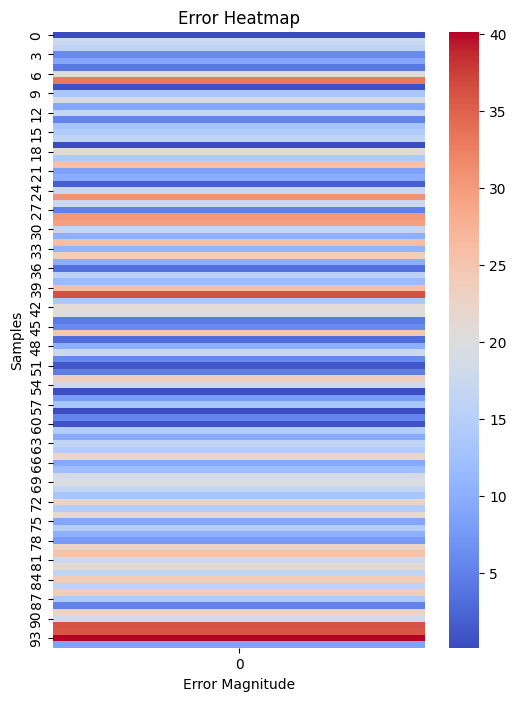

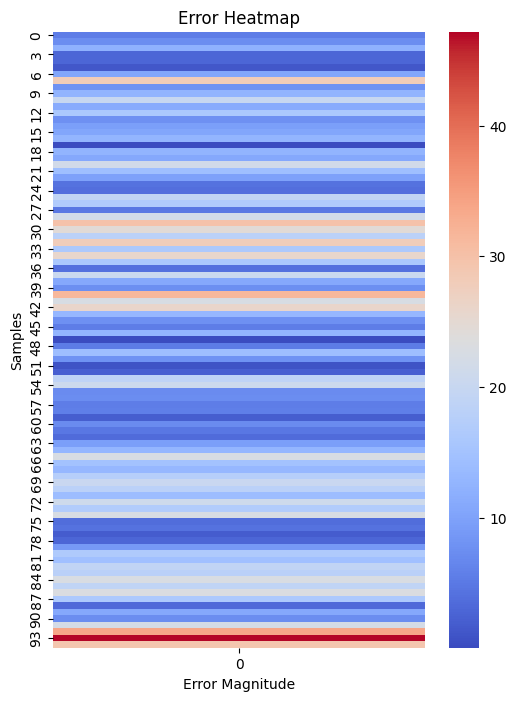

In [108]:
plot_error_heatmap(y_test_inv, lstm_preds_inv)
plot_error_heatmap(y_test_inv, gru_preds_inv)

In [109]:
models = ['LSTM', 'GRU']
rmse_scores = [rmse_lstm, rmse_gru]
mae_scores = [mae_lstm, mae_gru]
r2_scores = [r2_lstm, r2_gru]
mape_scores = [mape_lstm, mape_gru]

performance_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'MAE': mae_scores,
    'R2 Score': r2_scores,
    'MAPE (%)': mape_scores
})
print(performance_df)


  Model       RMSE        MAE  R2 Score  MAPE (%)
0  LSTM  17.598279  15.075454  0.116118  1.914753
1   GRU  16.084938  13.459725  0.261599  1.712811


### Analysis

In [ ]:
import matplotlib.pyplot as plt


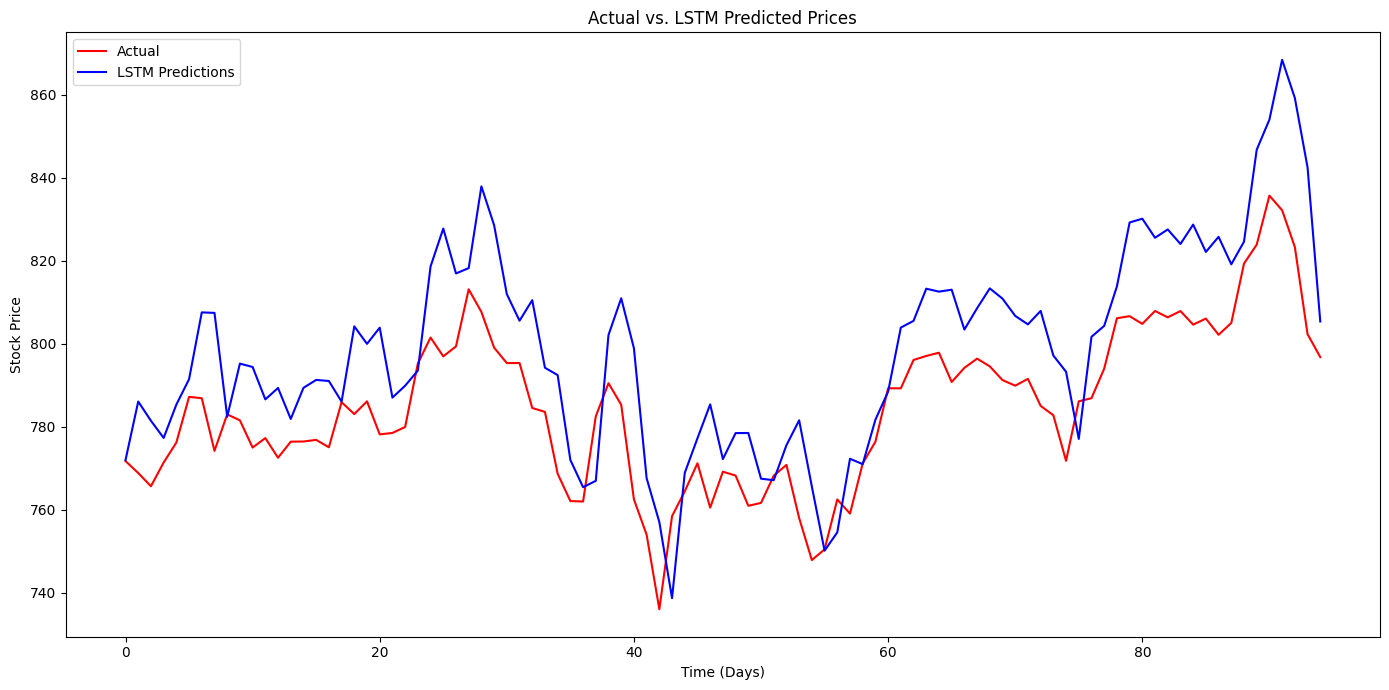

In [112]:
plt.figure(figsize=(14,7))
plt.plot(y_test_inv, color='red', label='Actual')
plt.plot(lstm_preds_inv, color='blue', label='LSTM Predictions')
plt.title('Actual vs. LSTM Predicted Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()

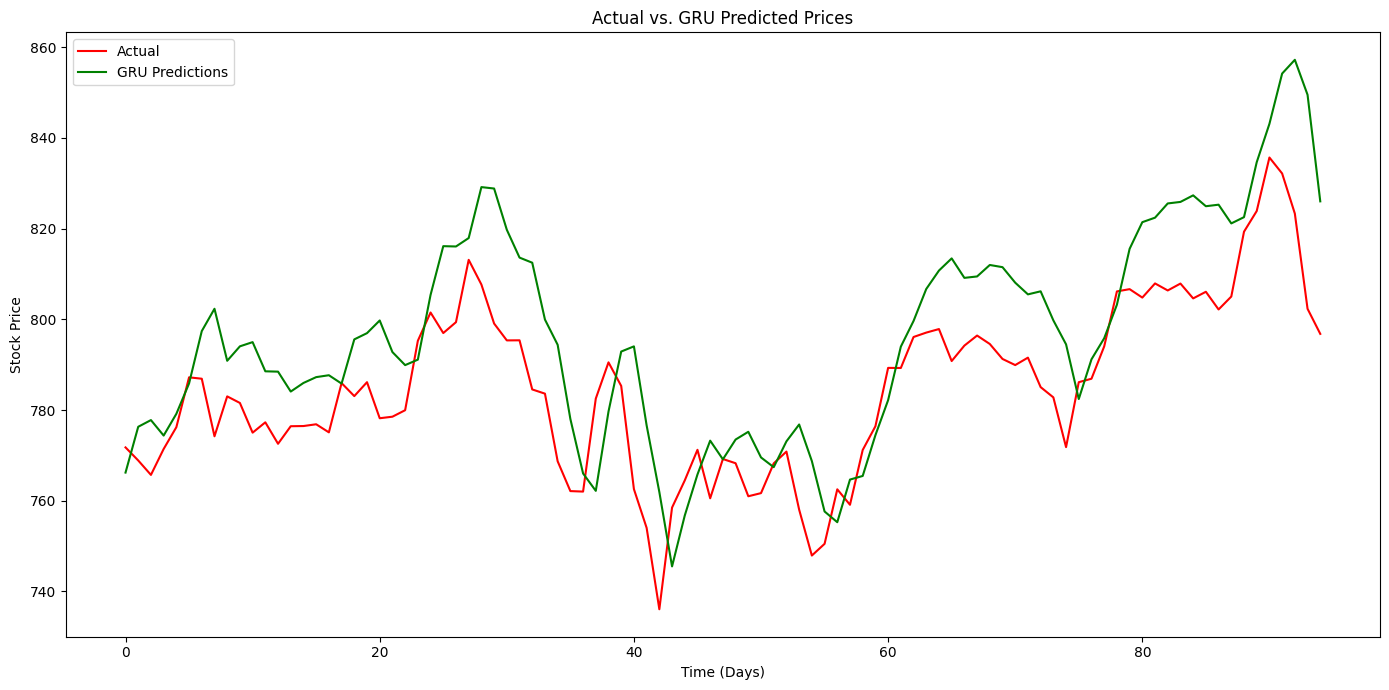

In [113]:
plt.figure(figsize=(14,7))
plt.plot(y_test_inv, color='red', label='Actual')
plt.plot(gru_preds_inv, color='green', label='GRU Predictions')
plt.title('Actual vs. GRU Predicted Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()


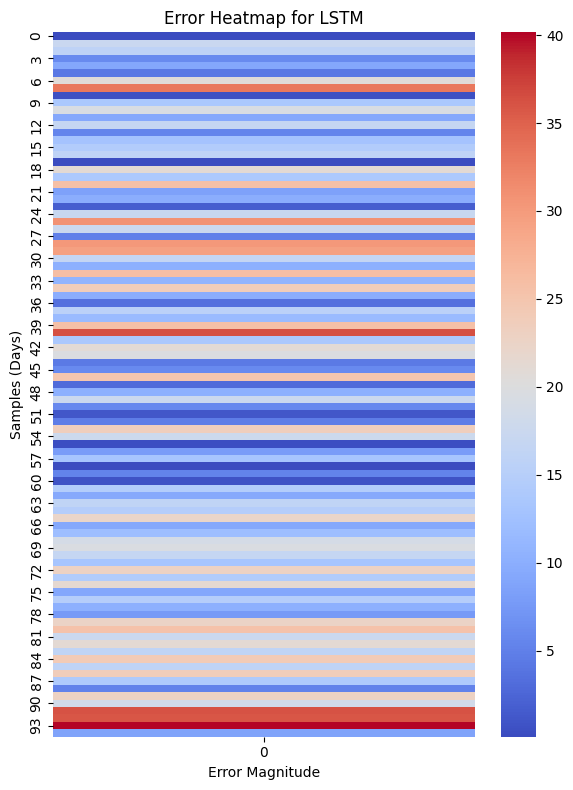

In [114]:
lstm_errors = np.abs(y_test_inv - lstm_preds_inv).reshape(-1, 1)

plt.figure(figsize=(6,8))
sns.heatmap(lstm_errors, cmap='coolwarm', annot=False, cbar=True)
plt.title('Error Heatmap for LSTM')
plt.xlabel('Error Magnitude')
plt.ylabel('Samples (Days)')
plt.tight_layout()
plt.show()

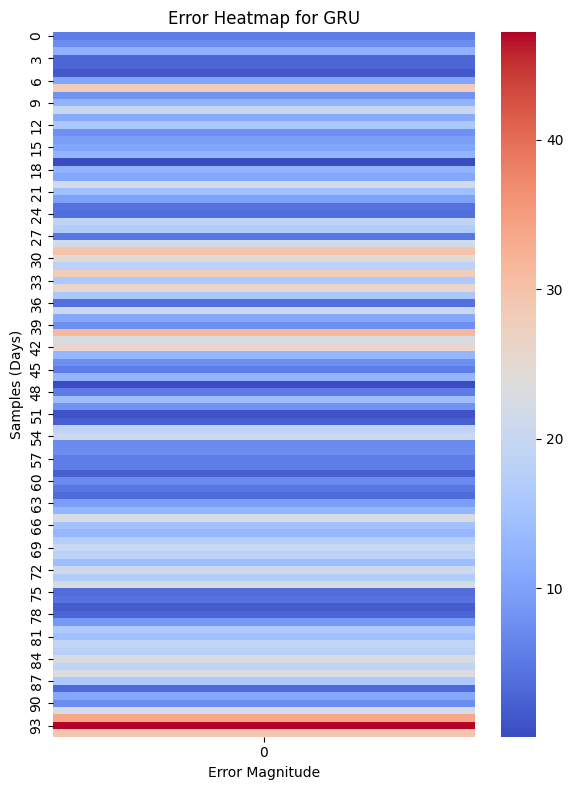

In [115]:
gru_errors = np.abs(y_test_inv - gru_preds_inv).reshape(-1, 1)

plt.figure(figsize=(6,8))
sns.heatmap(gru_errors, cmap='coolwarm', annot=False, cbar=True)
plt.title('Error Heatmap for GRU')
plt.xlabel('Error Magnitude')
plt.ylabel('Samples (Days)')
plt.tight_layout()
plt.show()